# Computer Vision - P6

### **Carefully read the file `README.md` as well as the following instructions before start coding.**

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Campus Virtual): January 2th, 23:59 h** 

## Haar-like features applied for face detection

Today's exercices will practise the following:

- Integral images and a classical use for fast harr-like feature computation.
- Use of Adaboost for classification.
- Decisions based on a user-defined threshold for balancing precision and recall.

In [163]:
# Some useful imports for the exercises
import numpy as np
import os, warnings
warnings.filterwarnings("ignore")
import matplotlib
from PIL import Image
#from multiprocessing import Pool
#from functools import partial
from skimage import io
import time
import timeit
from matplotlib import pyplot as plt

%matplotlib inline

**1) Build a function `to_integral_image` that computes the integral image of an input (2D) array.**

The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

```python
 def to_integral_image(img_arr):
    row_sum = np.zeros(img_arr.shape)
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    # Add here code
    
    return integral_image_arr
```


You can make the following tests:
 
 - `sum(img_array) == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`
 
Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```




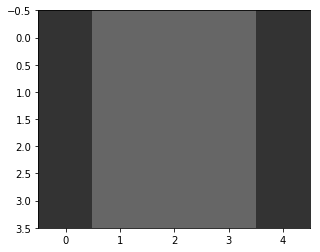

In [3]:
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
img_array.shape
plt.imshow(img_array, cmap="gray", vmin=0, vmax= 5)

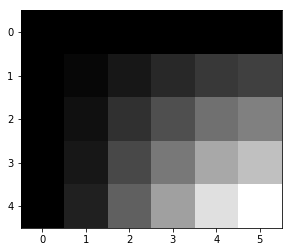

In [4]:
def to_integral_image(img_arr):
    """
    Calculates the integral image based on this instance's original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    # Since the integral image needs extra zeros row and colum an extended matrix is created.
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    
    # Iterative version.
    #r, c = img_arr.shape
    #integral_image_arr[1:, 1:] = np.array([np.array([np.sum(img_arr[:i+1, :j+1]) for j in range(c)]) for i in range(r)])
    
    # Using numpy's function for cumulative summatory.
    tmp = np.copy(img_arr)
    np.cumsum(tmp, axis=0, out=tmp)
    np.cumsum(tmp, axis=1, out=tmp)
    integral_image_arr[1:, 1:] = tmp
    
    return integral_image_arr

# Tests
ii_img_array = to_integral_image(img_array)
assert np.sum(img_array) == ii_img_array[-1,-1]
assert np.sum(img_array[0,:]) == ii_img_array[1,-1]

plt.imshow(ii_img_array, cmap='gray')

**2) Build a function to compute the sum of the pixel intensities within a rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.**

Make the function with the following header:
```
def sum_region(integral_img_arr, top_left, bottom_right):
```


In [164]:
def sum_region(integral_img_arr, top_left, bottom_right):
    
    r1, c1 = top_left[0], top_left[1]
    r2, c2 = bottom_right[0], bottom_right[1]
    
    """
    For some weird reason the exercise asks for a thing and the 'correct' result is another completely
    different.
    The exercise ask for the summatory of the pixels within a specified rectangle, which would be computed 
    by: np.sum(integral_img_arr[r1:r2, c1:c2]). However the 'correct' output is achieved by summing the
    specified corners and subtracting the other two.
    """
    return integral_img_arr[r1, c1] + integral_img_arr[r2, c2] - integral_img_arr[r1, c2] - integral_img_arr[r2, c1]

In [165]:
# result you should get (12)
sum_region(ii_img_array, [1,1],[3,4])

12.0

In [166]:
# result you should get (32)
sum_region(ii_img_array, [0,0],[-1,-1])

32.0

**3) Compute the integral image for all the following images:**
    
- training images of faces: save results in **`faces_ii_training`**
- testing images of face: save the results in **`faces_ii_testing`**
- training images of non faces: **`non_faces_ii_training`**
- testing images of non faces:  **`non_faces_ii_testing`**

To do so build a function to read all the images inside a given folder:

```python
def load_images(path):
    images = []
    for _file in os.listdir(path):
       #### Read image
       #### Remember to scale the image (wih the max pixel intensity value)
     
    return images
 ```

In [8]:
pos_training_path = "trainingdata/faces"
neg_training_path = "trainingdata/nonfaces"
pos_testing_path = "trainingdata/faces/test"
neg_testing_path = "trainingdata/nonfaces/test"

In [9]:
def load_images(path):
    
    # Normalizing function.
    normalize = lambda x: x/np.max(x)
    
    # Read, normalize and compute integral image of every ".png" file in the specified path, all in a cool
    # and compact list comprehension.
    return [to_integral_image(normalize(io.imread(path + "/" + file))) for file in os.listdir(path) 
            if file.endswith(".png")]

In [10]:
faces_ii_training = load_images(pos_training_path)
faces_ii_testing = load_images(pos_testing_path)
non_faces_ii_training = load_images(neg_training_path)
non_faces_ii_testing = load_images(neg_testing_path)

**4) Compute the Haar features of an image**

The code given will use the  `sum_region` function you have implemented to compute Haar-like features.
The following code, for example, will compute a vertical Haar-like feature
```python
    first = sum_region(int_img, 
                      self.top_left, 
                      (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
    second = sum_region(int_img, 
                       (self.top_left[0], int(self.top_left[1] + self.height / 2)),
                       self.bottom_right)
    score = first - second
```

We provide you with `HaarLikeFeature` class that has build in a `get_score` function and a `get_vote` function.

Your job is to 
```python
def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                # Loop over possible x values and y values 
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.
                # Notice that Haarlike features contain polarity, append features for polarity 1 and -1
                # The threshold can be set to 0 for all of them.
                
                
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features
```

In [15]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: violajonse.HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score
    
    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)


> ⚠️ **NOTICE:** Since the practicum can only be implemented in a Linux machine (Windows machine end up in an endless loop), the code meant to be ran with Pool to reduce execution time has been replaced with a nested loop. An attempt was made to replace the usage of the Pool library with Parallel, but it was taking more time than the execution time with nested loops. So there's that.
> Expect a longer execution time.

In [16]:
def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int
    :return: List of selected features
    :rtype: list[violajones.HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1))

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    #pool = Pool(processes=None)
    #for i in range(num_imgs):
    #    votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))
    
    for i in range(num_imgs):
        votes[i, :] = np.array([_get_feature_vote(features[j], images[i]) for j in range(len(features))])
    
    #for i in range(num_imgs):
    #    votes[i, :] = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(
    #    partial(_get_feature_vote))(j, images[j]) for j in features)
    
    print('\tTime needed for calculating scores:', time.time()-t0)
    
    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')


    return classifiers

def _get_feature_vote(feature, image):
    return feature.get_vote(image)

def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                
                # Iterate over possible x and y values.
                
                for x in range(img_width - feature_width):
                    for y in range(img_height - feature_height):
                        
                        # Two Haar features are created for every position. The first one has positive polarity whereas
                        # the second one has a negative one.
                        
                        # self, feature_type, position, width, height, threshold, polarity
                        h1 = HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, 1)
                        h2 = HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, -1)
                        
                        # The new features are added at the end of the feature list.
                        features.extend([h1, h2])
                        
            
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features

**5)Use the learn method to learn a list of classifiers with the train data**

With the `learn` function you can build a list of classifiers that detect whether an image contains a face or not.

Use the following hyperparameters of the features and `num_classifiers`.

In [13]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

### Aprox. wall time:  4 minutes

In [17]:
%%time
"""
faces_ii_training = load_images(pos_training_path)
faces_ii_testing = load_images(pos_testing_path)
non_faces_ii_training = load_images(neg_training_path)
non_faces_ii_testing = load_images(neg_testing_path)
"""
classifiers =  learn(faces_ii_training, non_faces_ii_training, num_classifiers=num_classifiers, 
                     min_feature_width=min_feature_width, max_feature_width=max_feature_width, 
                     min_feature_height=min_feature_height, max_feature_height=max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Harr-like features: 0.0039997100830078125
Calculating scores for images..
	Time needed for calculating scores: 176.31668424606323
Selecting classifiers..
	Time needed for Selecting Classifiers: 41.40884065628052 

Wall time: 3min 37s


**6) Make a function for voting with different classifiers**

Build two functions `ensemble_vote` and `ensemble_vote_all`.

- `ensemble_vote(int_img, classifiers)` has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise

- `ensemble_vote_all(int_imgs, classifiers)` has to loop over the list `int_imgs` and compute the `ensemble_vote` for each image in the list. It has to return a list containing all the votes for all the images in  `int_imgs`.

Use the functions to compute the train and test acurracies for faces and non faces.

Print the results in the following format:
```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [79]:
def ensemble_vote(int_img, classifiers):
    
    # Recover all votes from all classifiers.
    votes = np.sum([i.get_vote(int_img) for i in classifiers])
    
    # True if most votes are positive, false elsewhere. 
    return votes >= 0

def ensemble_vote_all(int_imgs, classifiers, percent=False):
    
    all_votes = [ensemble_vote(i, classifiers) for i in int_imgs]
    
    tot, pos = len(all_votes), np.sum(all_votes)
    
    if percent: return pos, tot, (pos/tot)*100
    
    return pos, tot

In [61]:
def print_results(pos_tr, neg_tr, pos_tst, neg_tst, classifiers):
    
    # Print results in the specified format.

    fpos_train, tn_train, fpcent_train = ensemble_vote_all(faces_ii_training, classifiers, percent=True)
    nfpos_train, tnf_train, nfpcent_train = ensemble_vote_all(non_faces_ii_training, classifiers, percent=True)

    fpos_test, tn_test, fpcent_test = ensemble_vote_all(faces_ii_testing, classifiers, percent=True)
    nfpos_test, tnf_test, nfpcent_test = ensemble_vote_all(non_faces_ii_testing, classifiers, percent=True)

    print("train results:")
    print("Correctly identified Faces: {}/{} ({}%)".format(fpos_train, tn_train, fpcent_train))
    print("Correctly identified non-Faces: {}/{} ({}%)\n".format(nfpos_train, tnf_train, nfpcent_train))
    print("test results:")
    print("Correctly identified Faces: {}/{} ({}%)".format(fpos_test, tn_test, fpcent_test))
    print("Correctly identified non-Faces: {}/{} ({}%)\n".format(nfpos_test, tnf_test, nfpcent_test))

In [62]:
print_results(faces_ii_training, non_faces_ii_training, faces_ii_testing, non_faces_ii_training, 
              classifiers)

train results:
Correctly identified Faces: 2130/2429 (87.6904075751338%)
Correctly identified non-Faces: 4274/8548 (50.0%)

test results:
Correctly identified Faces: 300/472 (63.559322033898304%)
Correctly identified non-Faces: 54/128 (42.1875%)



**7) Make another test with 20 classifiers instead of 2**

Inspect the classification results if you use adaboost with 20 classifiers. Use the same hyperameters for the features.
Print the results as in the previous exercise:

```
train results:
Correctly identified Faces: 2256/2429  (92.87772745986003%)
Correctly identified non-Faces: 7046/8548  (82.42863827795975%)

test results:
Correctly identified Faces: 285/472  (60.381355932203384%)
Correctly identified non-Faces: 104/128  (81.25%)
```

- Do the classification results improved in the train data?



In [27]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

### Aprox. wall time:   10 minutes

In [28]:
%%time
"""
faces_ii_training = load_images(pos_training_path)
faces_ii_testing = load_images(pos_testing_path)
non_faces_ii_training = load_images(neg_training_path)
non_faces_ii_testing = load_images(neg_testing_path)
"""
classifiers20 =  learn(faces_ii_training, non_faces_ii_training, num_classifiers=num_classifiers, 
                     min_feature_width=min_feature_width, max_feature_width=max_feature_width, 
                     min_feature_height=min_feature_height, max_feature_height=max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Harr-like features: 0.0039844512939453125
Calculating scores for images..
	Time needed for calculating scores: 172.37856197357178
Selecting classifiers..
	Time needed for Selecting Classifiers: 394.9684817790985 

Wall time: 9min 27s


In [63]:
print_results(faces_ii_training, non_faces_ii_training, faces_ii_testing, non_faces_ii_training, 
              classifiers20)

train results:
Correctly identified Faces: 2198/2429 (90.48991354466858%)
Correctly identified non-Faces: 1400/8548 (16.378100140383715%)

test results:
Correctly identified Faces: 272/472 (57.6271186440678%)
Correctly identified non-Faces: 21/128 (16.40625%)



**8) Change the voting functions so that you can set a threshold for deciding a prediction**

The threshold value indicates the minimum score for assigning a "positive" label (detect a face).

Create the following functions

- `ensemble_vote_t`: returns the final decision of a list of classifiers for a given threshold.
- `ensemble_vote_all_t`: Iterates over a list of integral images and returns the  final decision of a list of classifiers for each of the images (for a given threshold).



compute the following:

- a) number of correct faces over all faces (in the train data)
- b) number of correct non faces over all non faces (in the train data)
- c) number of correct faces over all faces (in the test data)
- d) number of correct non faces over all non faces (in the test data)

Using the list of 20 classifiers.


The quantities have to be computed for each of the following thresholds:

```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

- Make a bar bar plot for a) b) c) and d). In the x axis write the threshold value. 

- What happens when you increase the threshold value ?

In [77]:
def ensemble_vote_t(int_img, classifiers, threshold):
    
    # Recover all votes from all classifiers.
    votes = [i.get_vote(int_img) > threshold for i in classifiers]
    
    # As before, the vote is based on the majority of votes
    return np.sum(votes)/len(votes) > 0.5

def ensemble_vote_all_t(int_imgs, classifiers, threshold):
    
    # Votes for all images.
    return [ensemble_vote_t(i, classifiers, threshold) for i in int_imgs]

In [67]:
thresholds = np.array([x for x in range(-5,5,1)])/10.

In [167]:
def plot_results(ftrain, nftrain, ftst, nftst, thresholds):
    
    # Plot the results as specified on the exercise.
    
    n_ftrain, n_nftrain, n_ftst, n_nftst = len(ftrain), len(nftrain), len(ftst), len(nftst)
    
    print("Results for thresholds: {}\nLegend:".format(thresholds))
    print("\ta) Correct faces over all faces - train")
    print("\tb) Correct !faces over all non faces - train")
    print("\tc) Correct faces over all faces - test")
    print("\td) Correct !faces over all non faces - test")
    
    # Correct faces over all faces - train
    a = [np.sum(ftrain[i])/len(ftrain[i]) for i in range(n_nftrain)]
    # Correct !faces over all non faces - train
    b = [(len(nftrain[i]) - np.sum(nftrain[i]))/len(nftrain[i]) for i in range(n_nftrain)]
    # Correct faces over all faces - test
    c = [np.sum(ftst[i])/len(ftst[i]) for i in range(n_nftrain)]
    # Correct !faces over all non faces - test
    d = [(len(nftst[i]) - np.sum(nftst[i]))/len(nftst[i]) for i in range(n_nftrain)]
    
    # Plot values
    pa, = plt.plot(thresholds, a, label="a")
    pb, = plt.plot(thresholds, b, label="b")
    pc, = plt.plot(thresholds, c, label="c")
    pd, = plt.plot(thresholds, d, label="d")
    
    # Set title, label for x axis and its values and show the legend.
    plt.title("Results")
    plt.xlabel("Thresholds")
    plt.xticks(thresholds)
    plt.legend(handles=[pa, pb, pc, pd], fontsize='small', fancybox=True,  loc='best')
    
    plt.show()

In [78]:
correct_faces_train_t = [ensemble_vote_all_t(faces_ii_training, classifiers20, t) for t in thresholds]
correct_non_faces_train_t = [ensemble_vote_all_t(non_faces_ii_training, classifiers20, t) for t in thresholds]
correct_faces_test_t = [ensemble_vote_all_t(faces_ii_testing, classifiers20, t) for t in thresholds]
correct_non_faces_test_t = [ensemble_vote_all_t(non_faces_ii_testing, classifiers20, t) for t in thresholds]

Results for thresholds: [-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4]
Legend:
	a) Correct faces over all faces - train
	b) Correct !faces over all non faces - train
	c) Correct faces over all faces - test
	d) Correct !faces over all non faces - test


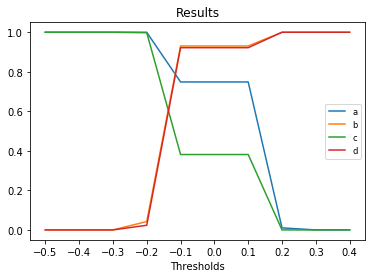

In [160]:
plot_results(correct_faces_train_t, correct_non_faces_train_t, correct_faces_test_t, 
             correct_non_faces_test_t, thresholds)

Results for thresholds: [-10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.   8.]
Legend:
	a) Correct faces over all faces - train
	b) Correct !faces over all non faces - train
	c) Correct faces over all faces - test
	d) Correct !faces over all non faces - test


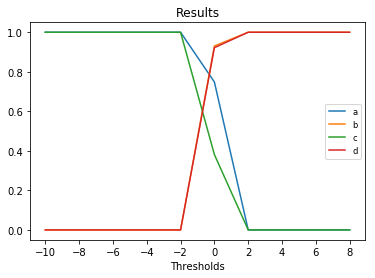

In [162]:
th = thresholds*20

correct_faces_train_t2 = [ensemble_vote_all_t(faces_ii_training, classifiers20, t) for t in th]
correct_non_faces_train_t2 = [ensemble_vote_all_t(non_faces_ii_training, classifiers20, t) for t in th]
correct_faces_test_t2 = [ensemble_vote_all_t(faces_ii_testing, classifiers20, t) for t in th]
correct_non_faces_test_t2 = [ensemble_vote_all_t(non_faces_ii_testing, classifiers20, t) for t in th]

plot_results(correct_faces_train_t2, correct_non_faces_train_t2, correct_faces_test_t2, 
             correct_non_faces_test_t2, th)

**Answer:** Augmenting the thresholds has resulted in outrageous and not representative results. To achieve better results (better accuracy), low thresholds.